# Training a Diffractive Beam Splitter


In [1]:
import torch
import torchoptics
import matplotlib.pyplot as plt

from torchoptics import Field, System, Param
from torchoptics.elements import PhaseModulator
from torchoptics.profiles import gaussian

In [2]:
shape = 250
waist_radius = 150e-6
device = "cuda" if torch.cuda.is_available() else "cpu"

torchoptics.set_default_spacing(10e-6)
torchoptics.set_default_wavelength(700e-9)

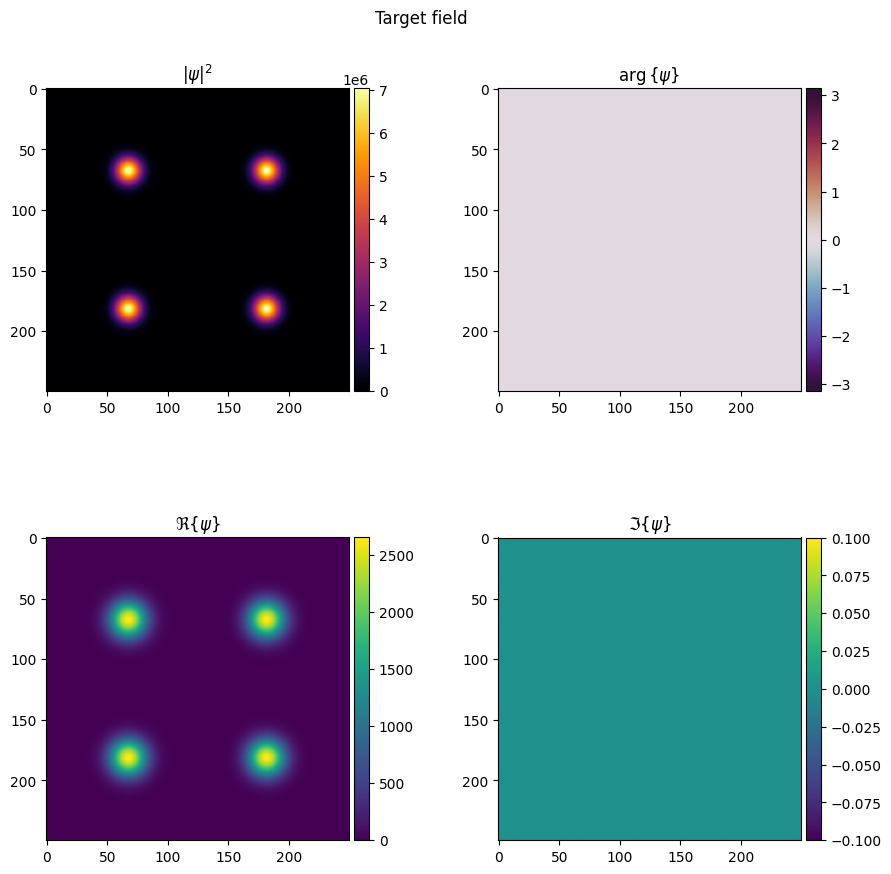

In [3]:
target_field_data = (
    gaussian(shape, waist_radius, offset=(3.8 * waist_radius, 3.8 * waist_radius))
    + gaussian(shape, waist_radius, offset=(3.8 * waist_radius, -3.8 * waist_radius))
    + gaussian(shape, waist_radius, offset=(-3.8 * waist_radius, 3.8 * waist_radius))
    + gaussian(shape, waist_radius, offset=(-3.8 * waist_radius, -3.8 * waist_radius))
) / 2
target_field = Field(target_field_data, z=0.6).to(device)

target_field.visualize(title="Target field")

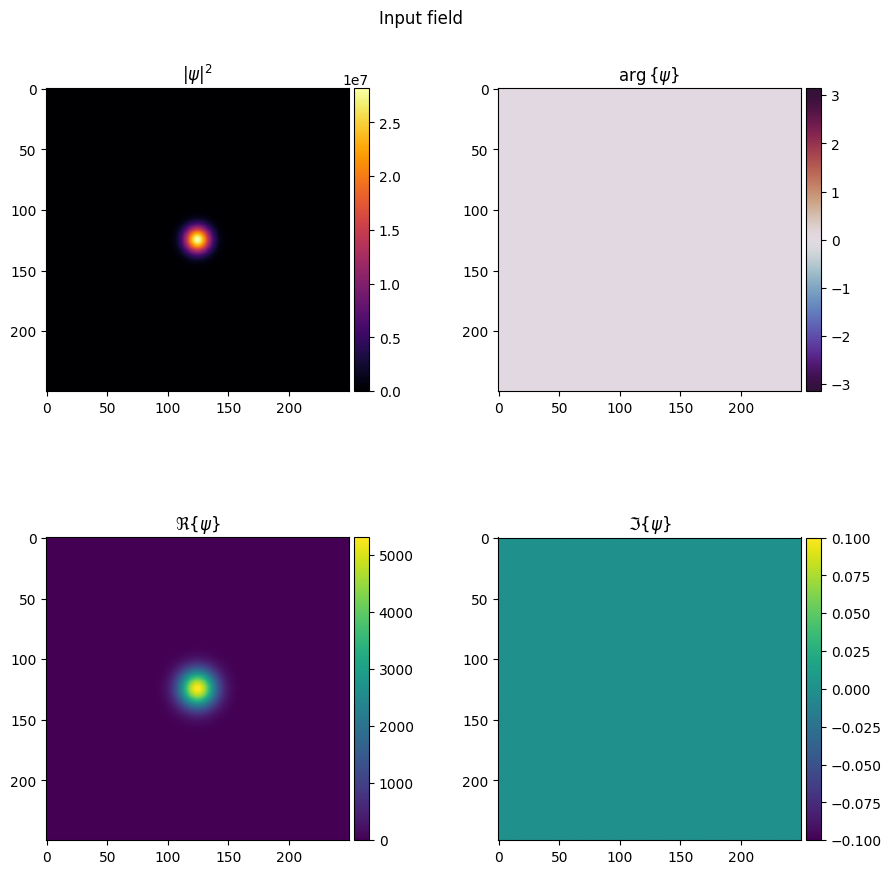

In [4]:
input_field = Field(gaussian(shape, waist_radius), z=0).to(device)
input_field.visualize(title="Input field")

In [5]:
system = System(
    PhaseModulator(Param(torch.zeros(shape, shape)), z=0.0),
    PhaseModulator(Param(torch.zeros(shape, shape)), z=0.2),
    PhaseModulator(Param(torch.zeros(shape, shape)), z=0.4),
).to(device)

In [6]:
optimizer = torch.optim.Adam(system.parameters(), lr=0.1)
losses = []
for iteration in range(400):
    optimizer.zero_grad()
    output_field = system.measure_at_z(input_field, 0.6)
    loss = 1 - output_field.inner(target_field).abs().square()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss {loss.item()}")

Iteration 0, Loss 0.9784589364195946
Iteration 10, Loss 0.5717267585639524
Iteration 20, Loss 0.2815336160348718
Iteration 30, Loss 0.13190796933571336
Iteration 40, Loss 0.07754239474673263
Iteration 50, Loss 0.051543123503664745
Iteration 60, Loss 0.037150648861515756
Iteration 70, Loss 0.02834961446952
Iteration 80, Loss 0.021785695486420842
Iteration 90, Loss 0.01605742414318967
Iteration 100, Loss 0.011977746351145013
Iteration 110, Loss 0.009444077022033315
Iteration 120, Loss 0.008084402492947507
Iteration 130, Loss 0.007148053046765135
Iteration 140, Loss 0.006397778150560973
Iteration 150, Loss 0.005732558499185969
Iteration 160, Loss 0.005136623763173698
Iteration 170, Loss 0.004607192743095512
Iteration 180, Loss 0.004142376633130995
Iteration 190, Loss 0.003790017611037144
Iteration 200, Loss 0.0035216642165128986
Iteration 210, Loss 0.0033207133301031977
Iteration 220, Loss 0.003160009974274014
Iteration 230, Loss 0.003047613653423764
Iteration 240, Loss 0.0029885632921293

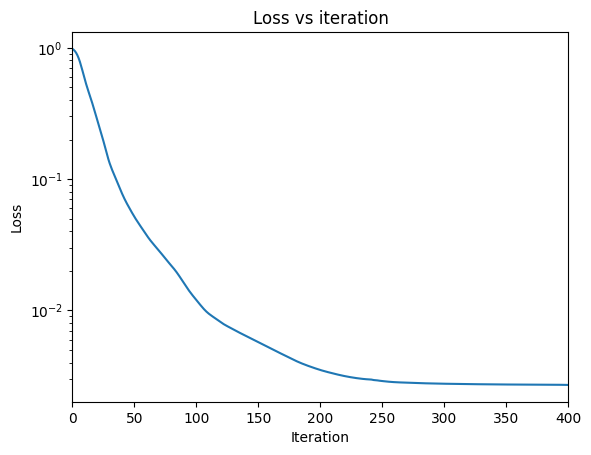

In [7]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs iteration")
plt.yscale("log")
plt.xlim(0, len(losses))
plt.show()

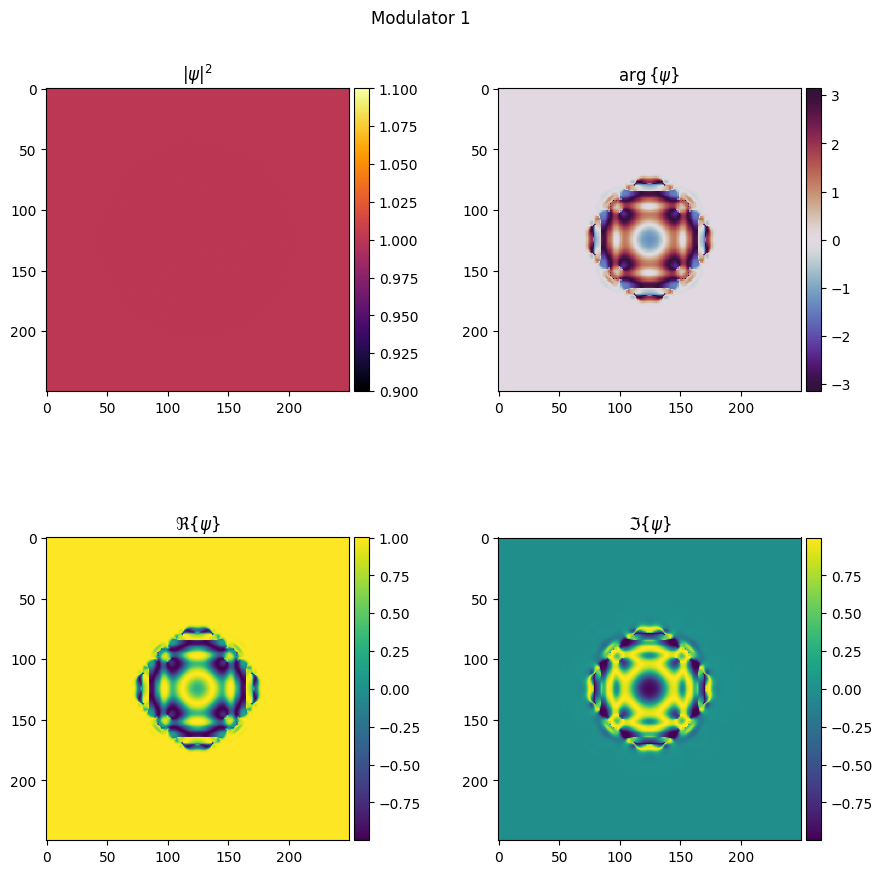

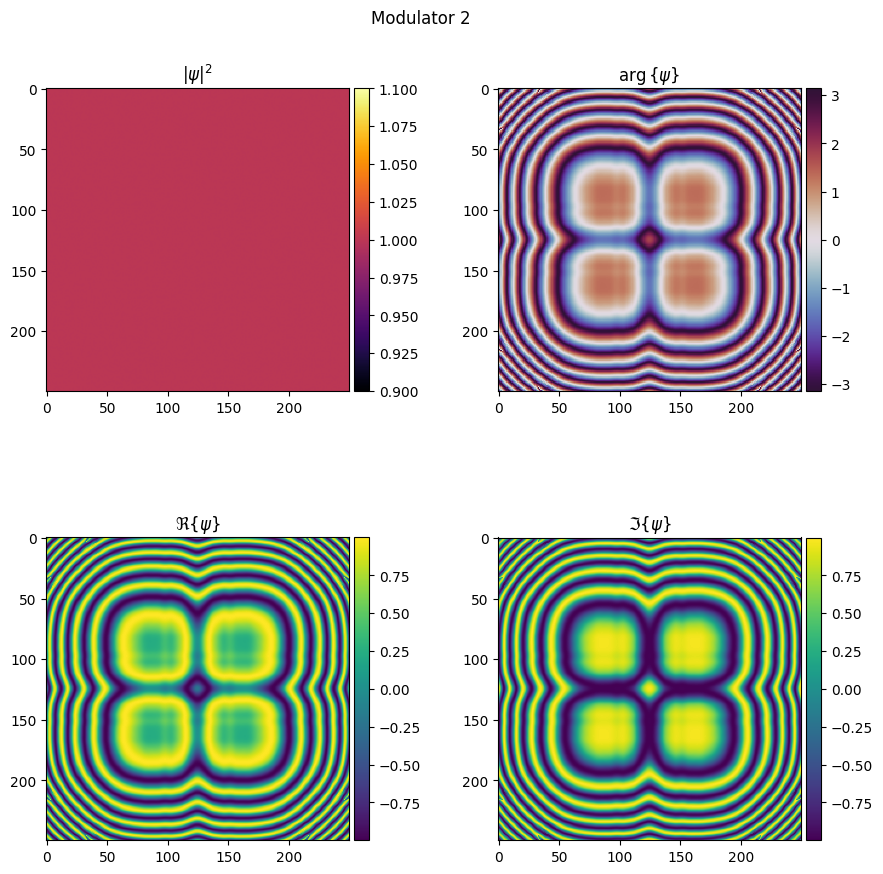

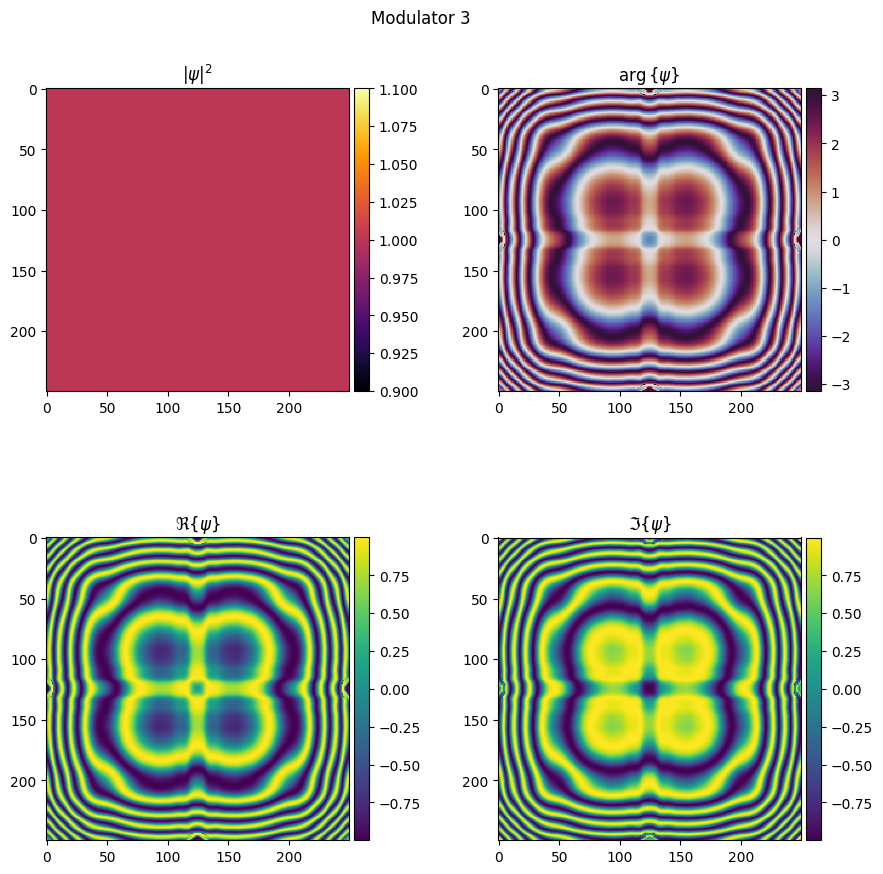

In [8]:
for i, element in enumerate(system):
    element.visualize(title=f"Modulator {i+1}")

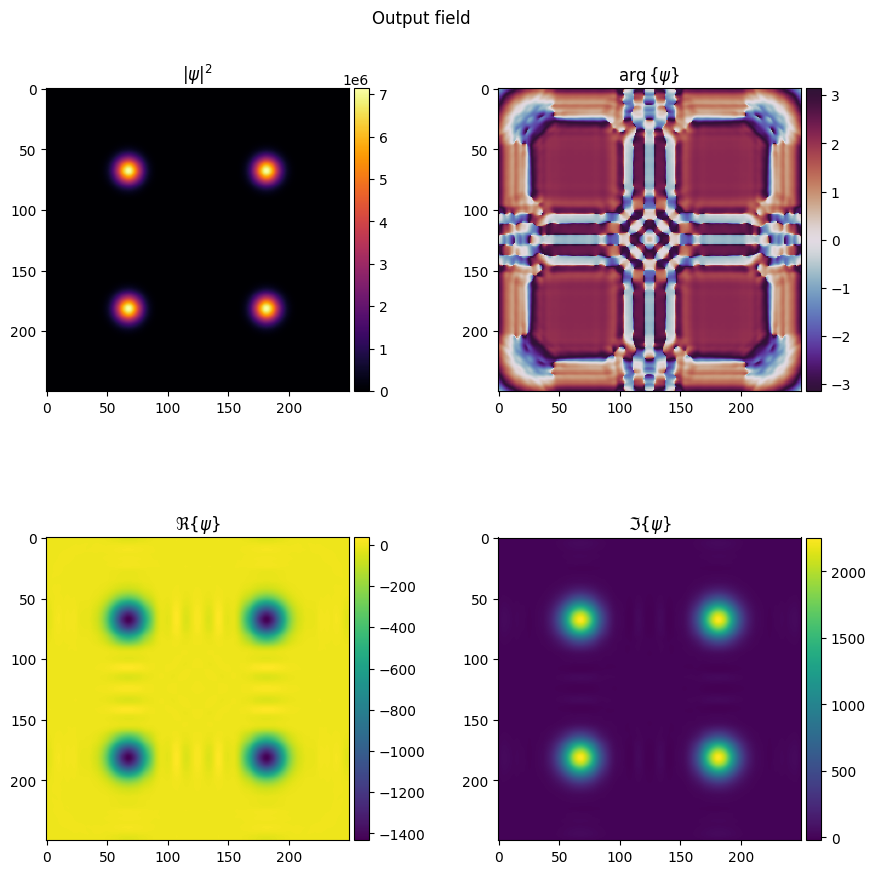

In [9]:
output_field = system.measure_at_z(input_field, 0.6)
output_field.visualize(title="Output field")